In [1]:
import pandas as pd
import networkx as nx
from collections import defaultdict, Counter
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Load and Process All Graphs

In [2]:
# Load Data Tables
academic     = pd.read_csv("data/academic.tsv",sep='\t')
advises      = pd.read_csv("data/advises.tsv",sep='\t')
degree_grant = pd.read_csv("data/degree_grant.tsv",sep='\t')
school       = pd.read_csv("data/school.tsv", sep='\t')
country      = pd.read_csv("data/country.tsv", sep='\t')
degree1 = pd.read_csv("data/new_degree.tsv", sep='\t',keep_default_na=True)

academic["Full_Name"] = academic.given_name + " " + academic.family_name

# Make Adjacency List & Graph
adj_list = list(zip(advises["advisor"], advises["advisee"]))
G = nx.DiGraph()
G.add_edges_from(adj_list)
G_undirect = G.to_undirected()

Fullname2ID = pd.Series(academic.academic_id.values, index=academic.Full_Name).to_dict()
ID2Name = pd.Series(academic.Full_Name.values,index=academic.academic_id).to_dict()
country2CN = pd.Series(country.country_name.values,index=country.country_id).to_dict()
nx.set_node_attributes(G, ID2Name, 'full_name')

## Medalist extraction and shortest path extraction

In [4]:
medalists     = pd.read_csv("data/medalists.csv",sep=',')
medalist_IDs = []

for i in medalists.Winner.values:
    ID = Fullname2ID[i]
    if i == "Paul Cohen":
        ID = 6479
    if i == "Michael Freedman":
        ID = 1365
    if i == "Alan Baker":
        ID = 22765
    
    if ID == 230591:
        ID = 93772
    if ID == 245820:
        ID = 15779
    if ID == 211588:
        ID = 6488
    G.nodes()[ID]["medalist"] = 1
    medalist_IDs.append(ID)

med_adj_list = []
for i in medalist_IDs:
    for j in medalist_IDs:
        if (i,j) in adj_list:
            med_adj_list.append((i,j))
# Gives nodes in subgraph
subgraph = defaultdict(int)
for i, a in enumerate(medalist_IDs):
    subgraph[a] = 1
    for j, b in enumerate(medalist_IDs[i+1:]):
        if nx.has_path(G_undirect,a,b):
            path_nodes = nx.shortest_path(G_undirect,a,b)
            for p in path_nodes:
                subgraph[p] = 1

#### Subgraph Extraction

In [13]:
subgraph_nodes = list(subgraph.keys())
K = G.subgraph(subgraph_nodes)
M = G.subgraph(medalist_IDs)

# Distributions

# Wiki Fullname

In [8]:
WIKI_FULL = pd.read_pickle("data/wiki_fullname.pkl")
Wiki_General = defaultdict(int)
Wiki_Specific = defaultdict(int)

for i, row in WIKI_FULL.iterrows():
    n = row.race
    general_region = n.split(",")[0] 
    specif_region  = n.split(",")[-1] 
    if specif_region == "Jewish":
        n = (row.iloc[4:].sort_values(ascending = False).index[1] )
        specif_region  = n.split(",")[-1]

    if specif_region == "Muslim":
        specif_region = "Arabic"
    elif specif_region == "Hispanic":
        specif_region = "Spanish"
    elif specif_region == "British":
        specif_region = "Anglo"
    Wiki_General[ row.academic_id ]  = general_region
    Wiki_Specific[ row.academic_id ] = specif_region

Text(0.5, 0, 'Representation (%)')

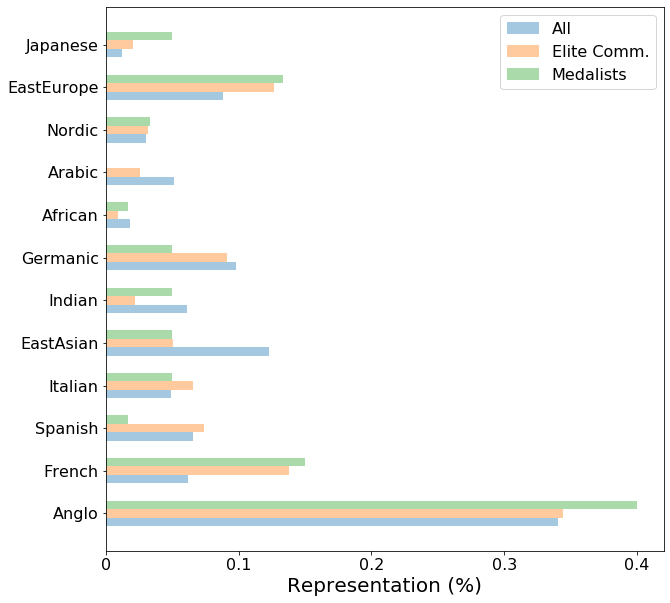

In [19]:
plt.figure(figsize=(10,10))
width = 0.2
G_distrib = [Wiki_Specific[n] for n in G.nodes()]
K_distrib = [Wiki_Specific[n] for n in K.nodes()]
M_distrib = [Wiki_Specific[n] for n in M.nodes()]

GG = Counter(G_distrib)
KK = Counter(K_distrib)
MM = Counter(M_distrib)
x = np.arange(len(GG.keys()))
GG_list = []
KK_list = []
MM_list = []
for k in GG.keys():
    GG_list.append( GG[k] / nx.number_of_nodes(G) )
    KK_list.append( KK[k] / nx.number_of_nodes(K) )
    MM_list.append( MM[k] / nx.number_of_nodes(M) )

ylabs = list(GG.keys())
ylabs[5] = "Indian"
ylabs[7] = "African"
ylabs[10]= "EastEurope"
    
matplotlib.rc('xtick', labelsize=10) 
plt.barh(x-0.2, GG_list , width, label = "All", alpha = 0.4)
plt.barh(x, KK_list , width, label = "Elite Comm.", alpha = 0.4)
plt.barh(x+0.2, MM_list , width, label = "Medalists", alpha = 0.4)
plt.xticks([0,0.1,0.2,0.3,0.4],[0,0.1,0.2,0.3,0.4],fontsize=16)
plt.yticks(x, ylabs,fontsize=16)
plt.legend(fontsize=16)
plt.xlabel("Representation (%)", fontsize=20)